## Import libraries

In [2]:
#from tensorflow.compat.v1.keras.models import Sequential
#from tensorflow.compat.v1.keras.layers import Dense
#from tensorflow.compat.v1.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import pandas as pd
import numpy as np
from six import string_types
from six.moves import xrange as range
from numpy import nan
import xlrd

import matplotlib.pyplot as plt 
import seaborn as sns
import pylab
from pylab import *

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, SCORERS, r2_score
from sklearn import linear_model, neighbors, tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kendalltau, spearmanr, pearsonr, variation
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import time
from tqdm.notebook import trange, tqdm
from time import sleep

RESULT_PATH = "results/"
FILE_PATH = 'Circ_Dataset.xlsx'

# fix random seed for reproducibility, random to be called before permutations in following blocks
seed = 4191995


## Dataset import and pre-process

In [3]:
# split into input (X) and output (Y) variables
DATA = np.array(pd.read_excel(FILE_PATH))
X = DATA[:,1:8]
Y = DATA[:,8:11]
Y = np.where(Y==0,np.nan,Y) 

#X = pd.DataFrame(X)
#print(X.info())
#Y = pd.DataFrame(Y)
#print(Y.info())

# Shuffle data
np.random.seed(seed)
p = np.random.permutation(len(X))
X = X[p]
np.random.seed(seed)
p = np.random.permutation(len(X))
Y = Y[p]

DATA = DATA[p]

# Normalize data
scaler = MinMaxScaler()
scaler.fit(X)
X_ = scaler.transform(X)


In [4]:
print((Y[:10])) # only display first 10 rows

[[       nan 2.9154519  4.97813411]
 [       nan 1.9160105  3.13648294]
 [       nan 2.5        4.        ]
 [3.64431487 7.65306122        nan]
 [       nan 3.5               nan]
 [4.15451895 4.59183673 4.59183673]
 [1.91466083 1.91466083 5.74398249]
 [       nan 0.63125    2.26875   ]
 [       nan        nan 6.62193325]
 [0.9375            nan 3.75      ]]


In [5]:
print(X.shape)
print(Y.shape)
Z = np.zeros([X.shape[0], X.shape[1]+Y.shape[1]])
print(Z.shape)

# Combine X and Y into Z
Z[:,:7] = X[:,:]
Z[:,7:] = Y[:,:]

(73, 7)
(73, 3)
(73, 10)


## Impute Output Values

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')
imp_mean.fit(Z)
SimpleImputer()
Z_ = imp_mean.transform(Z)
print(Z_.shape)

Y_ = Z_[:,7:]
print(Y_.shape)
print(Y_[:10])  # only display first 10 rows

(73, 10)
(73, 3)
[[2.88629738 2.9154519  4.97813411]
 [2.3438447  1.9160105  3.13648294]
 [1.76744505 2.5        4.        ]
 [3.64431487 7.65306122 5.45626822]
 [2.66292891 3.5        5.33823944]
 [4.15451895 4.59183673 4.59183673]
 [1.91466083 1.91466083 5.74398249]
 [1.42504377 0.63125    2.26875   ]
 [2.3438447  2.60696256 6.62193325]
 [0.9375     2.49086081 3.75      ]]


In [7]:
# Split into training and testing
train_all_ratio = 80/100
train_x = X_[:int(len(X)*train_all_ratio)]
test_x = X_[int(len(X)*train_all_ratio):]
test_x_original = X[int(len(X)*train_all_ratio):]
train_y = Y_[:int(len(X)*train_all_ratio)] # training targets contains inputed targets
test_y = Y[int(len(X)*train_all_ratio):] # testing targets are original targets

print('Total training data points: ', len(train_x))
print('Total testing data points: ', len(test_x))

Total training data points:  58
Total testing data points:  15


In [8]:
print(pd.DataFrame(test_y))

           0         1         2
0        NaN  2.600000  6.068890
1   2.840000  4.266667  7.106667
2   1.958425  2.943107  5.886214
3        NaN       NaN  6.835083
4        NaN  1.968504  3.116798
5   1.075269  2.150538       NaN
6   0.625000  1.250000       NaN
7        NaN  1.425000  2.850000
8        NaN       NaN  5.208333
9   1.967930  1.967930       NaN
10  0.833333  1.666667       NaN
11  1.457726  5.830904  5.830904
12       NaN       NaN  4.498480
13       NaN  1.181250       NaN
14  1.562500  2.083333  7.299869


## Define Reference Index proc

In [9]:
#Add 4 normalized columns to array
def Ref_IDX(GSA_array, num_desc):
    r, r2, SMAPE, RMSE, ref_idx = [],[],[],[],[]
    #replace possible pearson r errors (nan) with 0
    GSA_array = np.nan_to_num(GSA_array, nan=0.0)
    #iterate through all columns and normalize metric scores
    for i in range(len(GSA_array)):
        r.append((float(GSA_array[i,num_desc+0] - min(GSA_array[:,num_desc+0]))/float(max(GSA_array[:,num_desc+0])-min(GSA_array[:,num_desc+0]))))
        r2.append(float(GSA_array[i,num_desc+1] - min(GSA_array[:,num_desc+1]))/float(max(GSA_array[:,num_desc+1])-min(GSA_array[:,num_desc+1])))
        SMAPE.append(1-float(GSA_array[i,num_desc+2] - min(GSA_array[:,num_desc+2]))/float(max(GSA_array[:,num_desc+2])-min(GSA_array[:,num_desc+2])))
        RMSE.append(1-float(GSA_array[i,num_desc+3] - min(GSA_array[:,num_desc+3]))/float(max(GSA_array[:,num_desc+3])-min(GSA_array[:,num_desc+3])))
    #concatenate variables into a single array
    r = np.vstack(r)
    r2 = np.vstack(r2)
    SMAPE = np.vstack(SMAPE)
    RMSE = np.vstack(RMSE)
    norms = np.hstack((r, r2, SMAPE, RMSE))
    GSA_array = np.hstack((GSA_array,norms))
    #average normalized values to produce reference index
    for i in range(len(GSA_array)):
        ref_idx.append(((0.1*GSA_array[i,num_desc+4])+(0.3*GSA_array[i,num_desc+5])+(0.3*GSA_array[i,num_desc+6])+(0.3*GSA_array[i,num_desc+7])))
    ref_idx = np.vstack(ref_idx)
    GSA_array = np.hstack((GSA_array,ref_idx))
    #sort array in descending order ( higher ref_idx = better performance)
    GSA_array = GSA_array[np.argsort(-GSA_array[:, num_desc+8])]
    return GSA_array

In [10]:
import warnings
warnings.filterwarnings("ignore")

## Define ML Model processing functions

In [11]:
def RemoveNan(test, pred):
    trimmed_test = []
    trimmed_pred = []
    for i in range(len(test)):
        if np.isnan(test[i]) == False:
            trimmed_test.append(test[i])
            trimmed_pred.append(pred[i])
    trimmed_test = np.array(trimmed_test, dtype='float')
    trimmed_pred = np.array(trimmed_pred, dtype='float')
    return trimmed_test, trimmed_pred

def ML_MAE(test, pred):
    MAE = 0
    for i in range(len(test)):
        MAE += abs(test[i] - pred[i])
    MAE = MAE/len(test)    
    return MAE

def ML_RMSE(test, pred):
    MSE = 0
    for i in range(len(test)):
        MSE += (test[i] - pred[i])**2
    RMSE = (MSE/len(test))**0.5
    return RMSE

def ML_SMAPE(test, pred):
    SMAPE = 0
    for i in range(len(test)):
        SMAPE += abs(test[i] - pred[i])/((abs(test[i])+abs(pred[i]))/2)
    SMAPE = (100/len(test))*SMAPE
    return SMAPE

### Establish Neural Network Model

In [12]:
def train_and_test_NN(train_X, train_Y, test_X, test_Y, neur1, neur2, neur3, activ, splits, GSA_BEST):

    activ_funcs = {1: 'sigmoid', 2: 'relu', 3: 'tanh' }
    
    # Define Sequential Keras base model
    model = Sequential()
    model.add(Dense(neur1, input_dim=7, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    if neur2 != 0: #functionality for single hidden layer grid search
        model.add(Dense(neur2, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    if neur3 != 0: #functionality for two hidden layer grid search
        model.add(Dense(neur3, kernel_initializer='normal', activation= activ_funcs.get(activ)))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

    if splits == 0 or splits == 1: #does not perform KFold CV
            
        model.fit(train_X, train_Y, epochs=300, batch_size=8,  verbose=0)
        pred_y_nn = model.predict(test_X)
        pred_y_nn = np.hstack(pred_y_nn)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_nn)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([neur1, neur2, neur3, activ, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            model.fit(CV_train_X, CV_train_Y, epochs=300, batch_size=8,  verbose=0)
            pred_y_nn = model.predict(CV_test_X)
            pred_y_nn = np.hstack(pred_y_nn)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_nn)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([neur1, neur2, neur3, activ, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST


### Establish Linear Regression Model

In [13]:
def train_and_test_LR(train_X, train_Y, test_X, test_Y, splits, GSA_BEST):
    linear_regression = LinearRegression()

    if splits == 0 or splits == 1: #does not perform KFold CV
        linear_regression.fit(train_X, train_Y)
        pred_y_regression = linear_regression.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_regression)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            linear_regression.fit(CV_train_X, CV_train_Y)
            pred_y_regression = linear_regression.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_regression)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Ridge Regression Model

In [14]:
def train_and_test_RR(train_X, train_Y, test_X, test_Y, RR_Alpha, splits, GSA_BEST):
    RR = linear_model.Ridge(RR_Alpha)

    if splits == 0 or splits == 1: #does not perform KFold CV
        RR.fit(train_X, train_Y)
        pred_y_RR = RR.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_RR)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([RR_Alpha, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            RR.fit(CV_train_X, CV_train_Y)
            pred_y_RR = RR.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_RR)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([RR_Alpha, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Lasso Regression Model

In [15]:
def train_and_test_lasso(train_X, train_Y, test_X, test_Y, Lasso_Alpha, splits, GSA_BEST):
    Lasso = linear_model.Lasso(Lasso_Alpha)

    if splits == 0 or splits == 1: #does not perform KFold CV
        Lasso.fit(train_X, train_Y)
        pred_y_Lasso = Lasso.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_Lasso)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([Lasso_Alpha, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            Lasso.fit(CV_train_X, CV_train_Y)
            pred_y_Lasso = Lasso.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_Lasso)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([Lasso_Alpha, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish K-Nearest Neighbours Model

In [16]:
def train_and_test_KNN(train_X, train_Y, test_X, test_Y, N_neighbors, splits, GSA_BEST):
    knn = neighbors.KNeighborsRegressor(N_neighbors, weights="distance") # "uniform" or "distance"

    if splits == 0 or splits == 1: #does not perform KFold CV
        knn.fit(train_X, train_Y)
        pred_y_KNN = knn.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_KNN)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([N_neighbors, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            knn.fit(CV_train_X, CV_train_Y)
            pred_y_KNN = knn.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_KNN)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([N_neighbors, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Decision Tree Model

In [17]:
def train_and_test_DT(train_X, train_Y, test_X, test_Y, GSA_depth, splits, GSA_BEST):
    if GSA_depth == 0:
        GSA_depth = None
    DecisionTree = DecisionTreeRegressor(max_depth = GSA_depth, random_state = seed)

    if splits == 0 or splits == 1: #does not perform KFold CV
        DecisionTree.fit(train_X, train_Y)
        pred_y_DT = DecisionTree.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_DT)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([GSA_depth, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            DecisionTree.fit(CV_train_X, CV_train_Y)
            pred_y_DT = DecisionTree.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_DT)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([GSA_depth, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Random Forest Model

In [18]:
def train_and_test_RF(train_X, train_Y, test_X, test_Y, M_Bootstrap, Estimators, splits, GSA_BEST):
    RandomForest = RandomForestRegressor(n_estimators = Estimators, random_state = seed, max_samples= M_Bootstrap) 

    if splits == 0 or splits == 1: #does not perform KFold CV
        RandomForest.fit(train_X, train_Y)
        pred_y_RF = RandomForest.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_RF)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([M_Bootstrap, Estimators, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            RandomForest.fit(CV_train_X, CV_train_Y)
            pred_y_RF = RandomForest.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_RF)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([M_Bootstrap, Estimators, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

### Establish Support Vector Machine Model

In [19]:
def train_and_test_SVR(train_X, train_Y, test_X, test_Y, kern, SVR_C, degr, SV_epsilon, splits, GSA_BEST):
    
    kern_funcs = {1: 'linear', 2: 'poly', 3: 'rbf', 4: 'sigmoid' }
    SVMR = SVR(kernel=kern_funcs.get(kern), C=SVR_C, gamma='auto', degree=degr, epsilon=SV_epsilon) 
    
    if splits == 0 or splits == 1: #does not perform KFold CV
        SVMR.fit(train_X, train_Y)
        pred_y_SVMR = SVMR.predict(test_X)
        test_y_, pred_y_  =  RemoveNan(test_Y,pred_y_SVMR)
        MAE = ML_MAE(test = test_y_, pred = pred_y_)
        RMSE = ML_RMSE(test = test_y_, pred = pred_y_)
        SMAPE = ML_SMAPE(test = test_y_, pred = pred_y_)
        r = pearsonr(pred_y_, test_y_)[0]
        r2 = r2_score(test_y_, pred_y_)
        GSA_BEST.append([kern, SVR_C, degr, SV_epsilon, r, r2, SMAPE, RMSE])
        return pred_y_, test_y_, GSA_BEST
    else:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(train_X)
        r, r2, SMAPE, RMSE = [],[],[],[]
        for train_index, test_index in kf.split(train_X):
            CV_train_X, CV_test_X = train_X[train_index], train_X[test_index]
            CV_train_Y, CV_test_Y = train_Y[train_index], train_Y[test_index]
            SVMR.fit(CV_train_X, CV_train_Y)
            pred_y_SVMR = SVMR.predict(CV_test_X)
            CV_test_y_, CV_pred_y_  =  RemoveNan(CV_test_Y,pred_y_SVMR)
            
            RMSE.append(ML_RMSE(test = CV_test_y_, pred = CV_pred_y_))
            SMAPE.append(ML_SMAPE(test = CV_test_y_, pred = CV_pred_y_))
            r.append(pearsonr(CV_pred_y_, CV_test_y_)[0])
            r2.append(r2_score(CV_test_y_, CV_pred_y_))
            
        RMSE = sum(RMSE)/len(RMSE) 
        SMAPE = sum(SMAPE)/len(SMAPE) 
        r = sum(r)/len(r) 
        r2 = sum(r2)/len(r2) 
        GSA_BEST.append([kern, SVR_C, degr, SV_epsilon, r, r2, SMAPE, RMSE])
        return CV_pred_y_, CV_test_y_, GSA_BEST

# 5-Fold CV Grid Search All Models

In [19]:
best_nn_1 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in tqdm(Neurons,desc='GSA Loop 1'): 
    for GSA_neur2 in tqdm(Neurons,desc='GSA Loop 2',leave = False):
        for GSA_neur3 in tqdm(Neurons,desc='GSA Loop 3',leave = False): 
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_1, test_y_nn_1, best_nn_1 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_1)
                
#Convert returned GSA results to np array
best_nn_1=np.vstack(best_nn_1)

#Normalize metrics and compute reference index
best_nn_1 = Ref_IDX(GSA_array = best_nn_1, num_desc = 4)    

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_1 = pd.DataFrame(best_nn_1[:3],columns = headings)
best_nn_1


NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,80.000,80.000,64.000,2.000,0.779,0.285,13.974,0.433,0.992,0.976,0.950,1.000,0.977
1,112.000,112.000,96.000,2.000,0.780,0.079,13.082,0.451,0.994,0.888,1.000,0.960,0.954
2,64.000,64.000,64.000,2.000,0.758,0.257,14.101,0.454,0.954,0.964,0.943,0.951,0.953


In [20]:
best_nn_2 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in tqdm(Neurons,desc='GSA Loop 1'): 
    for GSA_neur2 in tqdm(Neurons,desc='GSA Loop 2',leave = False):
        for GSA_neur3 in tqdm(Neurons,desc='GSA Loop 3',leave = False): 
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_2, test_y_nn_2, best_nn_2 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_2)
                
#Convert returned GSA results to np array
best_nn_2=np.vstack(best_nn_2)

#Normalize metrics and compute reference index
best_nn_2 = Ref_IDX(GSA_array = best_nn_2, num_desc = 4)     

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_2 = pd.DataFrame(best_nn_2[:3],columns = headings)
best_nn_2


NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,128.000,112.000,48.000,2.000,0.818,0.560,18.427,0.723,0.979,1.000,1.000,1.000,0.998
1,128.000,112.000,80.000,2.000,0.803,0.540,18.442,0.750,0.961,0.983,0.999,0.951,0.976
2,96.000,48.000,48.000,2.000,0.797,0.554,20.012,0.725,0.954,0.995,0.920,0.996,0.969


In [21]:
best_nn_3 = []
Neurons = range(0, 136,16)
Activations = list(range(1,4)) #see dictionary definition in above function.
for GSA_neur1 in tqdm(Neurons,desc='GSA Loop 1'): 
    for GSA_neur2 in tqdm(Neurons,desc='GSA Loop 2',leave = False):
        for GSA_neur3 in tqdm(Neurons,desc='GSA Loop 3',leave = False): 
            for GSA_activ in Activations: 
                if GSA_neur3 > GSA_neur2 or GSA_neur2 > GSA_neur1 or GSA_neur1 == 0:
                    continue
                pred_y_nn_3, test_y_nn_3, best_nn_3 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], neur1 = GSA_neur1, neur2 = GSA_neur2, neur3 = GSA_neur3, activ = GSA_activ, splits = 5, GSA_BEST = best_nn_3)
                
#Convert returned GSA results to np array
best_nn_3=np.vstack(best_nn_3)

#Normalize metrics and compute reference index
best_nn_3 = Ref_IDX(GSA_array = best_nn_3, num_desc = 4)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
print('NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh')
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE','norm-r','norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_nn_3 = pd.DataFrame(best_nn_3[:3],columns = headings)
best_nn_3


NOTE: for Activ column, 1 = sigmoid || 2 = relu || 3 = tanh


,Neur1,Neur2,Neur3,Activ,r,r2,SMAPE,RMSE,norm-r,norm-r2,norm-SMAPE,norm-RMSE,INDEX
0,112.000,112.000,80.000,2.000,0.839,0.576,15.343,1.073,0.978,1.000,0.990,1.000,0.995
1,128.000,112.000,112.000,2.000,0.846,0.569,15.255,1.094,0.986,0.992,0.996,0.980,0.989
2,128.000,128.000,96.000,2.000,0.830,0.548,15.195,1.110,0.968,0.972,1.000,0.964,0.977


In [22]:
best_lr_1,best_lr_2, best_lr_3 = [], [], []
pred_y_lr_1, test_y_lr_1, best_lr_1  = train_and_test_LR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],splits = 5, GSA_BEST = best_lr_1)
pred_y_lr_2, test_y_lr_2, best_lr_2 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],splits = 5, GSA_BEST = best_lr_2)
pred_y_lr_3, test_y_lr_3, best_lr_3 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],splits = 5, GSA_BEST = best_lr_3)

#Convert returned GSA results to np array
best_lr_1=np.vstack(best_lr_1)
best_lr_2=np.vstack(best_lr_2)
best_lr_3=np.vstack(best_lr_3)

#Print best configuration of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['r','r2','SMAPE','RMSE']
best_lr_1 = pd.DataFrame(best_lr_1[:1],columns = headings)
print(best_lr_1)
best_lr_2 = pd.DataFrame(best_lr_2[:1],columns = headings)
print(best_lr_2)
best_lr_3 = pd.DataFrame(best_lr_3[:1],columns = headings)
print(best_lr_3)


      r     r2  SMAPE  RMSE
0 0.301 -0.122 21.277 0.623
      r     r2  SMAPE  RMSE
0 0.451 -0.046 26.797 1.069
      r     r2  SMAPE  RMSE
0 0.441 -0.275 28.646 1.994


In [23]:
best_rr_1,best_rr_2, best_rr_3 = [], [], []
# Train and test 3 models, GSA Alpha Values from 10^-6 to 10^6
for GSA_Alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]: 
    pred_y_rr_1, test_y_rr_1, best_rr_1  = train_and_test_RR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_1)
    pred_y_rr_2, test_y_rr_2, best_rr_2 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_2)
    pred_y_rr_3, test_y_rr_3, best_rr_3 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],RR_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_rr_3)
    
#Convert returned GSA results to np array
best_rr_1=np.vstack(best_rr_1)
best_rr_2=np.vstack(best_rr_2)
best_rr_3=np.vstack(best_rr_3)

#Normalize metrics and compute reference index
best_rr_1 = Ref_IDX(GSA_array = best_rr_1, num_desc = 1)    
best_rr_2 = Ref_IDX(GSA_array = best_rr_2, num_desc = 1)     
best_rr_3 = Ref_IDX(GSA_array = best_rr_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.6f}".format
headings = ['RR_Alpha','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_rr_1 = pd.DataFrame(best_rr_1[:3],columns = headings)
print(best_rr_1)
best_rr_2 = pd.DataFrame(best_rr_2[:3],columns = headings)
print(best_rr_2)
best_rr_3 = pd.DataFrame(best_rr_3[:3],columns = headings)
print(best_rr_3)

   RR_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  1.000000 0.294052 -0.042403 20.855159 0.605376 0.583202 1.000000    1.000000   1.000000 0.958320
1  0.100000 0.298408 -0.083046 20.959576 0.610888 0.850969 0.491058    0.937576   0.823318 0.760683
2  0.010000 0.300502 -0.114208 21.221940 0.620518 0.979675 0.100839    0.780726   0.514580 0.516811
   RR_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  0.000010 0.450722 -0.045609 26.797433 1.069142 1.000000 0.892295    1.000000   0.996726 0.966706
1  0.000100 0.450718 -0.045585 26.800162 1.069138 0.999957 0.892438    0.998220   0.996768 0.966223
2  0.001000 0.450679 -0.045344 26.827134 1.069099 0.999514 0.893852    0.980619   0.997178 0.961446
   RR_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0  1.000000 0.503895  0.066529 24.460260 1.762208 0.690768 1.000000    1.000000   1.000000 0.969077


In [24]:
best_lasso_1,best_lasso_2, best_lasso_3 = [], [], []
# Train and test 3 models, GSA Alpha Values from 10^-6 to 10^6
for GSA_Alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]: 
    pred_y_Lasso_1, test_y_Lasso_1, best_lasso_1  = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],Lasso_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_lasso_1)
    pred_y_Lasso_2, test_y_Lasso_2, best_lasso_2 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],Lasso_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_lasso_2)
    pred_y_Lasso_3, test_y_Lasso_3, best_lasso_3 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],Lasso_Alpha = GSA_Alpha, splits = 5, GSA_BEST = best_lasso_3)
    
#Convert returned GSA results to np array
best_lasso_1=np.vstack(best_lasso_1)
best_lasso_2=np.vstack(best_lasso_2)
best_lasso_3=np.vstack(best_lasso_3)

#Normalize metrics and compute reference index
best_lasso_1 = Ref_IDX(GSA_array = best_lasso_1, num_desc = 1)    
best_lasso_2 = Ref_IDX(GSA_array = best_lasso_2, num_desc = 1)     
best_lasso_3 = Ref_IDX(GSA_array = best_lasso_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.6f}".format
headings = ['Lasso_Alpha','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_lasso_1 = pd.DataFrame(best_lasso_1[:3],columns = headings)
print(best_lasso_1)
best_lasso_2 = pd.DataFrame(best_lasso_2[:3],columns = headings)
print(best_lasso_2)
best_lasso_3 = pd.DataFrame(best_lasso_3[:3],columns = headings)
print(best_lasso_3)

   Lasso_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0     0.010000 0.274815 -0.065882 20.895626 0.611413 0.911857 1.000000    0.985836   1.000000 0.986937
1     0.001000 0.301380 -0.103189 20.872176 0.617483 1.000000 0.336097    1.000000   0.758742 0.728451
2     0.000100 0.300834 -0.120325 21.234391 0.622370 0.998190 0.031147    0.781232   0.564475 0.512875
   Lasso_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0     0.000010 0.450718 -0.045519 26.802597 1.069126 1.000000 0.959387    1.000000   0.993434 0.985846
1     0.000100 0.450682 -0.044692 26.851229 1.068983 0.999918 0.964598    0.976123   0.994921 0.980684
2     0.001000 0.449565 -0.039073 27.289192 1.068495 0.997440 1.000000    0.761095   1.000000 0.928073
   Lasso_Alpha        r        r2     SMAPE     RMSE   norm-r  norm-r2  norm-SMAPE  norm-RMSE    INDEX
0     0.010000 0.477294 -0.121470 27.167006 1.889165 0.994855 1.000000   

In [25]:
best_knn_1,best_knn_2, best_knn_3 = [], [], []
# Train and test 3 models, GSA Neighbour Amounts from 2 to 25
for GSA_NN in range(2,26): 
    pred_y_knn_1, test_y_knn_1,best_knn_1 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_1 )
    pred_y_knn_2, test_y_knn_2,best_knn_2 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_2 )
    pred_y_knn_3, test_y_knn_3,best_knn_3 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], N_neighbors = GSA_NN, splits = 5, GSA_BEST = best_knn_3 )

#Convert returned GSA results to np array
best_knn_1=np.vstack(best_knn_1)
best_knn_2=np.vstack(best_knn_2)
best_knn_3=np.vstack(best_knn_3)

#Normalize metrics and compute reference index
best_knn_1 = Ref_IDX(GSA_array = best_knn_1, num_desc = 1)    
best_knn_2 = Ref_IDX(GSA_array = best_knn_2, num_desc = 1)     
best_knn_3 = Ref_IDX(GSA_array = best_knn_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['#NN','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_knn_1 = pd.DataFrame(best_knn_1[:3],columns = headings)
print(best_knn_1)
best_knn_2 = pd.DataFrame(best_knn_2[:3],columns = headings)
print(best_knn_2)
best_knn_3 = pd.DataFrame(best_knn_3[:3],columns = headings)
print(best_knn_3)

    #NN     r     r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 7.000 0.501 -0.375 19.722 0.633   1.000    1.000       0.851      1.000  0.955
1 6.000 0.495 -0.413 19.609 0.638   0.960    0.855       0.876      0.902  0.886
2 8.000 0.474 -0.432 20.643 0.642   0.828    0.782       0.644      0.797  0.750
    #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000 0.696 0.229 24.048 0.936   0.810    1.000       0.974      1.000  0.973
1 4.000 0.674 0.193 24.167 0.957   0.653    0.934       0.954      0.887  0.898
2 6.000 0.722 0.192 25.104 0.951   1.000    0.933       0.798      0.922  0.896
     #NN     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 11.000 0.700 0.272 21.441 1.541   0.998    1.000       0.994      0.998  0.997
1 10.000 0.699 0.268 21.420 1.540   0.984    0.985       1.000      1.000  0.994
2  9.000 0.693 0.260 21.582 1.551   0.934    0.954       0.956      0.961  0.955


In [26]:
best_dt_1,best_dt_2, best_dt_3 = [], [], []
# Train and test 3 models, GSA max_depths Amounts from 0 (None) to 10
for Depths in range(0,11): 
    pred_y_dt_1, test_y_dt_1,best_dt_1 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_1 )
    pred_y_dt_2, test_y_dt_2,best_dt_2 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_2 )
    pred_y_dt_3, test_y_dt_3,best_dt_3 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GSA_depth = Depths, splits = 5, GSA_BEST = best_dt_3 )

#Convert returned GSA results to np array
best_dt_1=np.vstack(best_dt_1)
best_dt_2=np.vstack(best_dt_2)
best_dt_3=np.vstack(best_dt_3)

#Normalize metrics and compute reference index
best_dt_1 = Ref_IDX(GSA_array = best_dt_1, num_desc = 1)    
best_dt_2 = Ref_IDX(GSA_array = best_dt_2, num_desc = 1)     
best_dt_3 = Ref_IDX(GSA_array = best_dt_3, num_desc = 1)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['Max_Depth','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_dt_1 = pd.DataFrame(best_dt_1[:3],columns = headings)
print(best_dt_1)
best_dt_2 = pd.DataFrame(best_dt_2[:3],columns = headings)
print(best_dt_2)
best_dt_3 = pd.DataFrame(best_dt_3[:3],columns = headings)
print(best_dt_3)

  Max_Depth     r     r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     1.000 0.635  0.403 16.998 0.485  1.000   1.000      1.000     1.000 1.000
1     2.000 0.546 -0.282 17.553 0.579  0.479   0.600      0.802     0.576 0.641
2     3.000 0.558 -0.686 18.374 0.626  0.547   0.364      0.510     0.368 0.427
  Max_Depth     r    r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     3.000 0.593 0.116 24.287 0.976  0.951   1.000      1.000     1.000 0.995
1     4.000 0.600 0.101 24.664 0.989  0.962   0.978      0.958     0.955 0.964
2     8.000 0.615 0.062 26.019 1.021  0.989   0.921      0.808     0.847 0.872
  Max_Depth     r    r2  SMAPE  RMSE norm-r norm-r2 norm-SMAPE norm-RMSE INDEX
0     6.000 0.647 0.169 20.143 1.643  0.964   1.000      1.000     1.000 0.996
1     4.000 0.659 0.160 20.967 1.670  1.000   0.978      0.856     0.922 0.927
2     7.000 0.574 0.085 20.992 1.732  0.750   0.780      0.852     0.739 0.786


In [27]:
best_rf_1,best_rf_2, best_rf_3 = [], [], []
# Train and test 3 models, GSA Tree amount Values from 50 to 1500, m values = 2,3,4,5

m_values = range(1,6)
tree_amounts = range(50,1050,50)

for GSA_m in tqdm(m_values,desc='GSA Loop 1'): 
    for GSA_trees in tqdm(tree_amounts,desc='GSA Loop 2',leave = False): 
        pred_y_rf_1, test_y_rf_1, best_rf_1 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_1)
        pred_y_rf_2, test_y_rf_2, best_rf_2 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_2)
        pred_y_rf_3, test_y_rf_3, best_rf_3 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],M_Bootstrap = GSA_m, Estimators = GSA_trees, splits = 5, GSA_BEST = best_rf_3)
    
#Convert returned GSA results to np array
best_rf_1=np.vstack(best_rf_1)
best_rf_2=np.vstack(best_rf_2)
best_rf_3=np.vstack(best_rf_3)

#Normalize metrics and compute reference index
best_rf_1 = Ref_IDX(GSA_array = best_rf_1, num_desc = 2)    
best_rf_2 = Ref_IDX(GSA_array = best_rf_2, num_desc = 2)     
best_rf_3 = Ref_IDX(GSA_array = best_rf_3, num_desc = 2)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.3f}".format
headings = ['m','Trees','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_rf_1 = pd.DataFrame(best_rf_1[:3],columns = headings)
print(best_rf_1)
best_rf_2 = pd.DataFrame(best_rf_2[:3],columns = headings)
print(best_rf_2)
best_rf_3 = pd.DataFrame(best_rf_3[:3],columns = headings)
print(best_rf_3)


      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000  50.000 0.577 0.158 19.899 0.566   0.924    1.000       1.000      1.000  0.992
1 5.000 100.000 0.592 0.139 20.011 0.572   0.947    0.930       0.964      0.911  0.936
2 4.000  50.000 0.625 0.120 20.014 0.576   1.000    0.862       0.963      0.862  0.906
      m     Trees     r     r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 5.000 1,000.000 0.631 -0.051 27.936 1.053   0.949    1.000       0.679      1.000  0.899
1 5.000   950.000 0.629 -0.052 27.926 1.053   0.946    0.991       0.686      0.999  0.897
2 5.000   600.000 0.648 -0.066 27.845 1.055   0.974    0.900       0.739      0.985  0.885
      m   Trees     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 3.000  50.000 0.594 0.062 23.858 1.745   0.878    0.984       1.000      1.000  0.983
1 5.000 100.000 0.581 0.061 24.045 1.753   0.859    0.981       0.966      0.980  0.964
2 5.000 250.000 0.6

In [28]:
best_svmr_1,best_svmr_2, best_svmr_3 = [], [], []
# Train and test 3 models, Various GSA parameters (This takes a while)
Kernels = list(range(1,5)) #see dictionary definition in above function.
C_list = [*range(1,11)] + [*range(50,1050,50)]
Degrees = list(range(3,6))
Epsilons = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

for GSA_kern in Kernels: 
    for GSA_C in C_list: 
        for GSA_degr in Degrees: 
            for GSA_eps in Epsilons: 
                if GSA_kern != 2 and GSA_degr != 5:
                    continue
                pred_y_svmr_1, test_y_svmr_1, best_svmr_1 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_1)
                pred_y_svmr_2, test_y_svmr_2, best_svmr_2 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_2)
                pred_y_svmr_3, test_y_svmr_3, best_svmr_3 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], kern = GSA_kern, SVR_C = GSA_C, degr = GSA_degr, SV_epsilon = GSA_eps, splits = 5, GSA_BEST = best_svmr_3)
                
#Convert returned GSA results to np array
best_svmr_1=np.vstack(best_svmr_1)
best_svmr_2=np.vstack(best_svmr_2)
best_svmr_3=np.vstack(best_svmr_3)

#Normalize metrics and compute reference index
best_svmr_1 = Ref_IDX(GSA_array = best_svmr_1, num_desc = 4)    
best_svmr_2 = Ref_IDX(GSA_array = best_svmr_2, num_desc = 4)     
best_svmr_3 = Ref_IDX(GSA_array = best_svmr_3, num_desc = 4)  

#Print 3 best configurations of each model
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = "{:,.5f}".format
headings = ['Kern', 'C', 'degr', 'eps','r', 'r2','SMAPE','RMSE','norm-r', 'norm-r2','norm-SMAPE','norm-RMSE','INDEX']
best_svmr_1 = pd.DataFrame(best_svmr_1[:3],columns = headings)
print(best_svmr_1)
best_svmr_2 = pd.DataFrame(best_svmr_2[:3],columns = headings)
print(best_svmr_2)
best_svmr_3 = pd.DataFrame(best_svmr_3[:3],columns = headings)
print(best_svmr_3)

   Kern       C  degr   eps     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 3.000 100.000 5.000 0.010 0.468 0.055 17.898 0.577   0.979    0.997       0.999      0.994  0.995
1 3.000 100.000 5.000 0.000 0.464 0.052 17.863 0.577   0.973    0.997       1.000      0.994  0.995
2 3.000 100.000 5.000 0.001 0.465 0.052 17.878 0.577   0.974    0.997       1.000      0.994  0.995
   Kern       C  degr   eps     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 1.000  50.000 5.000 0.100 0.464 0.101 23.501 1.038   0.810    1.000       0.993      0.998  0.978
1 4.000 100.000 5.000 0.001 0.463 0.075 23.265 1.053   0.809    0.998       0.998      0.993  0.978
2 1.000 100.000 5.000 0.100 0.457 0.098 23.624 1.040   0.801    1.000       0.990      0.997  0.976
   Kern       C  degr   eps     r    r2  SMAPE  RMSE  norm-r  norm-r2  norm-SMAPE  norm-RMSE  INDEX
0 2.000 550.000 4.000 0.000 0.588 0.098 22.940 1.720   0.893    0.999       0.977      0.999  0.982


## Optimal Model Configurations

In [31]:
best_nn_1,best_nn_2, best_nn_3 = [], [], []
pred_y_nn_1, test_y_nn_1, best_nn_1 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], neur1 = 80, neur2 = 80, neur3 = 64, activ = 2, splits = 1, GSA_BEST = best_nn_1)
pred_y_nn_2, test_y_nn_2, best_nn_2 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], neur1 = 128, neur2 = 112, neur3 = 48, activ = 2, splits = 1, GSA_BEST = best_nn_2)
pred_y_nn_3, test_y_nn_3, best_nn_3 = train_and_test_NN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], neur1 = 112, neur2 = 112, neur3 = 80, activ = 2, splits = 1, GSA_BEST = best_nn_3)
headings = ['Neur1', 'Neur2', 'Neur3', 'Activ','r','r2','SMAPE','RMSE']
best_nn_1 = pd.DataFrame(best_nn_1,columns = headings)
best_nn_2 = pd.DataFrame(best_nn_2,columns = headings)
best_nn_3 = pd.DataFrame(best_nn_3,columns = headings)

best_lr_1,best_lr_2, best_lr_3 = [], [], []
pred_y_lr_1, test_y_lr_1, best_lr_1  = train_and_test_LR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],splits = 1, GSA_BEST = best_lr_1)
pred_y_lr_2, test_y_lr_2, best_lr_2 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],splits = 1, GSA_BEST = best_lr_2)
pred_y_lr_3, test_y_lr_3, best_lr_3 = train_and_test_LR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],splits = 1, GSA_BEST = best_lr_3)
headings = ['r','r2','SMAPE','RMSE']
best_lr_1 = pd.DataFrame(best_lr_1,columns = headings)
best_lr_2 = pd.DataFrame(best_lr_2,columns = headings)
best_lr_3 = pd.DataFrame(best_lr_3,columns = headings)

best_rr_1,best_rr_2, best_rr_3 = [], [], []
pred_y_rr_1, test_y_rr_1, best_rr_1 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],RR_Alpha = 1.000000, splits = 1, GSA_BEST = best_rr_1)
pred_y_rr_2, test_y_rr_2, best_rr_2 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],RR_Alpha = 0.000010, splits = 1, GSA_BEST = best_rr_2)
pred_y_rr_3, test_y_rr_3, best_rr_3 = train_and_test_RR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],RR_Alpha = 1.000000, splits = 1, GSA_BEST = best_rr_3)
headings = ['RR_Alpha','r','r2','SMAPE','RMSE']
best_rr_1 = pd.DataFrame(best_rr_1,columns = headings)
best_rr_2 = pd.DataFrame(best_rr_2,columns = headings)
best_rr_3 = pd.DataFrame(best_rr_3,columns = headings)

best_lasso_1,best_lasso_2, best_lasso_3 = [], [], []
pred_y_Lasso_1, test_y_Lasso_1, best_lasso_1  = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],Lasso_Alpha = 0.010000 , splits = 1, GSA_BEST = best_lasso_1)
pred_y_Lasso_2, test_y_Lasso_2, best_lasso_2 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],Lasso_Alpha = 0.000010 , splits = 1, GSA_BEST = best_lasso_2)
pred_y_Lasso_3, test_y_Lasso_3, best_lasso_3 = train_and_test_lasso(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],Lasso_Alpha = 0.010000 , splits = 1, GSA_BEST = best_lasso_3)
headings = ['Lasso_Alpha','r','r2','SMAPE','RMSE']
best_lasso_1 = pd.DataFrame(best_lasso_1,columns = headings)
best_lasso_2 = pd.DataFrame(best_lasso_2,columns = headings)
best_lasso_3 = pd.DataFrame(best_lasso_3,columns = headings)

best_knn_1,best_knn_2, best_knn_3 = [], [], []
pred_y_knn_1, test_y_knn_1,best_knn_1 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], N_neighbors = 7, splits = 1, GSA_BEST = best_knn_1 )
pred_y_knn_2, test_y_knn_2,best_knn_2 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], N_neighbors = 5, splits = 1, GSA_BEST = best_knn_2 )
pred_y_knn_3, test_y_knn_3,best_knn_3 = train_and_test_KNN(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], N_neighbors = 11, splits = 1, GSA_BEST = best_knn_3 )
headings = ['# NN','r','r2','SMAPE','RMSE']
best_knn_1 = pd.DataFrame(best_knn_1,columns = headings)
best_knn_2 = pd.DataFrame(best_knn_2,columns = headings)
best_knn_3 = pd.DataFrame(best_knn_3,columns = headings)

best_dt_1,best_dt_2, best_dt_3 = [], [], []
pred_y_dt_1, test_y_dt_1,best_dt_1 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], GSA_depth = 1, splits = 1, GSA_BEST = best_dt_1 )
pred_y_dt_2, test_y_dt_2,best_dt_2 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], GSA_depth = 3, splits = 1, GSA_BEST = best_dt_2 )
pred_y_dt_3, test_y_dt_3,best_dt_3 = train_and_test_DT(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], GSA_depth = 6, splits = 1, GSA_BEST = best_dt_3 )
headings = ['Max_Depth','r','r2','SMAPE','RMSE']
best_dt_1 = pd.DataFrame(best_dt_1[:5],columns = headings)
best_dt_2 = pd.DataFrame(best_dt_2[:5],columns = headings)
best_dt_3 = pd.DataFrame(best_dt_3[:5],columns = headings)

best_rf_1,best_rf_2, best_rf_3 = [], [], []
pred_y_rf_1, test_y_rf_1, best_rf_1 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0],M_Bootstrap = 5, Estimators = 50, splits = 1, GSA_BEST = best_rf_1)
pred_y_rf_2, test_y_rf_2, best_rf_2 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1],M_Bootstrap = 5, Estimators = 1000, splits = 1, GSA_BEST = best_rf_2)
pred_y_rf_3, test_y_rf_3, best_rf_3 = train_and_test_RF(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2],M_Bootstrap = 5, Estimators = 50, splits = 1, GSA_BEST = best_rf_3)
headings = ['m','# Estimators','r','r2','SMAPE','RMSE']
best_rf_1 = pd.DataFrame(best_rf_1,columns = headings)
best_rf_2 = pd.DataFrame(best_rf_2,columns = headings)
best_rf_3 = pd.DataFrame(best_rf_3,columns = headings)

best_svmr_1,best_svmr_2, best_svmr_3 = [], [], []
pred_y_svmr_1, test_y_svmr_1, best_svmr_1 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,0], test_X = test_x, test_Y = test_y[:,0], kern = 3, SVR_C = 100, degr = 5, SV_epsilon = 0.01000, splits = 1, GSA_BEST = best_svmr_1)
pred_y_svmr_2, test_y_svmr_2, best_svmr_2 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,1], test_X = test_x, test_Y = test_y[:,1], kern = 1, SVR_C = 50, degr = 5, SV_epsilon = 0.10000, splits = 1, GSA_BEST = best_svmr_2)
pred_y_svmr_3, test_y_svmr_3, best_svmr_3 = train_and_test_SVR(train_X = train_x, train_Y = train_y[:,2], test_X = test_x, test_Y = test_y[:,2], kern = 2, SVR_C = 550, degr = 4, SV_epsilon = 0.00001, splits = 1, GSA_BEST = best_svmr_3)
headings = ['Kern', 'C', 'degr', 'eps','r','r2','SMAPE','RMSE']
best_svmr_1 = pd.DataFrame(best_svmr_1[:5],columns = headings)
best_svmr_2 = pd.DataFrame(best_svmr_2[:5],columns = headings)
best_svmr_3 = pd.DataFrame(best_svmr_3[:5],columns = headings)


## Split test inputs and outputs for clarity in following tables

In [32]:
test_y_1, test_y_2, test_y_3 = [], [], []
test_x_original_1, test_x_original_2, test_x_original_3 = pd.DataFrame(test_x_original), pd.DataFrame(test_x_original), pd.DataFrame(test_x_original)

for i in range(len(test_y)):
    if np.isnan(test_y[:,0][i]) == False:
        test_y_1.append(test_y[:,0][i])
    else:
        test_x_original_1 = test_x_original_1.drop(labels = i, axis = 0)
    if np.isnan(test_y[:,1][i]) == False:
        test_y_2.append(test_y[:,1][i])
    else:
        test_x_original_2 = test_x_original_2.drop(labels = i, axis = 0)
    if np.isnan(test_y[:,2][i]) == False:
        test_y_3.append(test_y[:,2][i])
    else:
        test_x_original_3 = test_x_original_3.drop(labels = i, axis = 0)
test_y_1 = np.array(test_y_1)
test_y_2 = np.array(test_y_2)
test_y_3 = np.array(test_y_3)    

## Define Normalizing func for results

In [33]:
#Add 4 normalized columns to array
def Norm(Array):
    norm_array = []
    #iterate through column and normalize metric scores
    for i in range(len(Array)):
        norm_array.append((Array[i]-min(Array))/(max(Array)-min(Array)))
    #Force list
    norm_array = list(norm_array)
    return norm_array

def Norm_inv(Array):
    invnorm_array = []
    #iterate through column and normalize metric scores
    for i in range(len(Array)):
        invnorm_array.append(1-((Array[i]-min(Array))/(max(Array)-min(Array))))
    #Force list
    invnorm_array = list(invnorm_array)
    return invnorm_array

def List_AVG(var1, var2, var3, var4):
    AVG = []
    #iterate through column and normalize metric scores
    for i in range(len(var1)):
        AVG.append((0.1*var1[i])+(0.3*var2[i])+(0.3*var3[i])+(0.3*var4[i]))
    #Force list
    AVG = list(AVG)
    return AVG

## Print Core Crushing Results

In [34]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[8])
head.append("ANN Prediction")
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("Lasso Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("Support Vector Prediction")
result.append(head[1:])

for i in range(len(test_y_1)):
    tmp = list(test_x_original_1.to_numpy()[i])
    tmp.append(test_y_1[i])
    tmp.append(pred_y_nn_1[i])
    tmp.append(pred_y_lr_1[i])
    tmp.append(pred_y_rr_1[i])
    tmp.append(pred_y_Lasso_1[i])
    tmp.append(pred_y_knn_1[i])
    tmp.append(pred_y_dt_1[i])
    tmp.append(pred_y_rf_1[i])
    tmp.append(pred_y_svmr_1[i])    
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Spiral (%),Core Crushing Drift (%),ANN Prediction,Linear Regression Prediction,Ridge Regression Prediction,Lasso Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,Support Vector Prediction
1,0.1,24.4,3,446,1.96,441,1.41,2.84,2.69729,2.3469,2.22361,2.22963,2.85688,2.48636,2.45346,2.35976
2,0.069,35.8,6.01316,475,2,493,0.63,1.95842,2.61849,2.55758,2.47489,2.45593,2.78973,2.48636,2.41196,2.46485
3,0.322,33,3.72,294,2.18,207,2.48,1.07527,0.226421,1.24913,1.56278,1.58343,1.64758,1.58029,2.25867,0.549049
4,0.386,32.9,2,303,2.43,423,0.8,0.625,1.33559,1.55476,1.56643,1.49439,1.78193,2.48636,2.32175,1.45851
5,0.094,29,4.49836,448,2.04,434,0.94,1.96793,3.00552,2.3381,2.29155,2.29568,2.8863,2.48636,2.62669,2.34123
6,0.227,28.4,2,303,2.43,300,0.75,0.833333,1.21622,1.51705,1.65596,1.66306,1.81649,1.58029,2.20544,1.09229
7,0.093,32.8,4.49836,448,2.04,434,0.94,1.45773,2.87038,2.33639,2.29403,2.29683,2.33236,2.48636,2.60994,2.34719
8,0.072,31,4,462,2.98,606.8,0.7,1.5625,3.33119,2.89549,2.4465,2.35803,3.10095,2.48636,2.42946,2.56365


## Print Concrete Spalling Results

In [35]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[9])
head.append("ANN Prediction")
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("Lasso Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("Support Vector Prediction")
result.append(head[1:])

for i in range(len(test_y_2)):
    tmp = list(test_x_original_2.to_numpy()[i])
    tmp.append(test_y_2[i])
    tmp.append(pred_y_nn_2[i])
    tmp.append(pred_y_lr_2[i])
    tmp.append(pred_y_rr_2[i])
    tmp.append(pred_y_Lasso_2[i])
    tmp.append(pred_y_knn_2[i])
    tmp.append(pred_y_dt_2[i])
    tmp.append(pred_y_rf_2[i])
    tmp.append(pred_y_svmr_2[i])    
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Spiral (%),Concrete Spalling Drift (%),ANN Prediction,Linear Regression Prediction,Ridge Regression Prediction,Lasso Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,Support Vector Prediction
1,0.05,30,5.997,420,2.19,420,0.294436,2.6,3.83366,3.33184,3.33184,3.33189,3.716,2.8299,3.39608,2.86966
2,0.1,24.4,3,446,1.96,441,1.41,4.26667,4.6569,3.63607,3.63605,3.63578,4.34302,4.75779,3.46617,3.20451
3,0.069,35.8,6.01316,475,2,493,0.63,2.94311,3.85166,3.4595,3.4595,3.45947,4.79285,3.21897,3.33146,3.03553
4,0.127,56.2,3,455,0.99,455,0.13,1.9685,2.98033,1.94298,1.94299,1.94336,2.98574,2.62787,3.01449,1.94147
5,0.322,33,3.72,294,2.18,207,2.48,2.15054,2.46679,2.50356,2.50358,2.50352,2.47521,2.92151,3.01759,2.37886
6,0.386,32.9,2,303,2.43,423,0.8,1.25,2.23935,2.55852,2.55848,2.55796,2.50288,2.8299,3.07533,2.63298
7,0.13,32.3,4,337,2.43,466,0.62,1.425,3.18934,3.64267,3.64264,3.64203,2.88623,4.75779,3.25718,3.44914
8,0.094,29,4.49836,448,2.04,434,0.94,1.96793,4.6136,3.37939,3.37939,3.37932,2.91545,4.75779,3.63232,2.9446
9,0.227,28.4,2,303,2.43,300,0.75,1.66667,1.99879,2.56182,2.56181,2.56163,2.86337,2.92151,3.02185,2.40661


## Print Bar Buckling Results

In [36]:
# show the inputs and predicted outputs
result = []
df = pd.read_excel(FILE_PATH)
head = list(df.columns[:8])
head.append(df.columns[10])
head.append("ANN Prediction")
head.append("Linear Regression Prediction")
head.append("Ridge Regression Prediction")
head.append("Lasso Regression Prediction")
head.append("KNN Prediction")
head.append("Decision Tree Prediction")
head.append("Random Forest Prediction")
head.append("Support Vector Prediction")
result.append(head[1:])

for i in range(len(test_y_3)):
    tmp = list(test_x_original_3.to_numpy()[i])
    tmp.append(test_y_3[i])
    tmp.append(pred_y_nn_3[i])
    tmp.append(pred_y_lr_3[i])
    tmp.append(pred_y_rr_3[i])
    tmp.append(pred_y_Lasso_3[i])
    tmp.append(pred_y_knn_3[i])
    tmp.append(pred_y_dt_3[i])
    tmp.append(pred_y_rf_3[i])
    tmp.append(pred_y_svmr_3[i])    
    result.append(tmp)
result = pd.DataFrame(result)

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Axial Load Ratio,f'c (MPa),Aspect Ratio,"fy, Longitudinal Bars (Mpa)",rho Long (%),"fy, Transverse Bars (Mpa)",rho Spiral (%),Bar Buckling Drift (%),ANN Prediction,Linear Regression Prediction,Ridge Regression Prediction,Lasso Regression Prediction,KNN Prediction,Decision Tree Prediction,Random Forest Prediction,Support Vector Prediction
1,0.05,30,5.997,420,2.19,420,0.294436,6.06889,5.18004,5.93857,6.00136,5.99681,5.18652,5.30222,5.65903,5.73492
2,0.1,24.4,3,446,1.96,441,1.41,7.10667,6.68617,6.46545,6.04139,6.34413,5.75217,5.86334,5.77217,5.64814
3,0.069,35.8,6.01316,475,2,493,0.63,5.88621,7.26641,7.21158,6.89595,7.15081,6.33847,6.23632,6.78536,7.05688
4,0.091,34.5,3,441.3,2.73,606.8,0.89,6.83508,5.98914,6.07807,5.95019,5.61138,5.88501,5.30222,6.14548,5.98513
5,0.127,56.2,3,455,0.99,455,0.13,3.1168,3.65156,4.27479,5.08923,4.43157,4.00504,3.71391,6.06485,5.00672
6,0.13,32.3,4,337,2.43,466,0.62,2.85,5.04564,4.06531,4.5892,3.90836,4.37515,4,5.58921,4.90863
7,0.12,37.2,4,462,1.49,606.8,0.7,5.20833,6.66063,6.03328,6.10239,5.84816,6.31712,5.30222,6.348,5.8782
8,0.093,32.8,4.49836,448,2.04,434,0.94,5.8309,6.72123,6.44343,6.21756,6.39833,5.8309,5.30222,5.87621,5.99629
9,0.419,90,6.58,419,3.28,1000,1.54,4.49848,5.52023,6.98156,7.06202,5.75569,7.89896,4,6.66529,8.86119


## Create Polar Graphs for Manuscript

Best Concrete Spalling Model: SVMR
Best Core Crushing Model: SVMR
Best Bar Buckling Model: DT


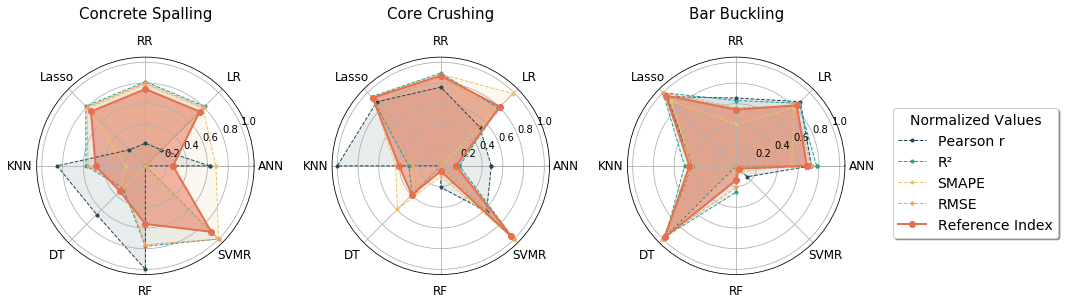

In [41]:
labels=np.array(['ANN', 'LR', 'RR', 'Lasso', 'KNN', 'DT', 'RF', 'SVMR'])
models = {0:'ANN',1: 'LR',2: 'RR',3: 'Lasso',4: 'KNN',5: 'DT',6: 'RF',7: 'SVMR'}
best_1, best_2, best_3 = [],[],[]
best_model = {0: best_1,1: best_2,2: best_3}
title_lbl= {1:'Core Crushing', 0:'Concrete Spalling', 2:'Bar Buckling'}
legend_lbl=np.array(['Pearson r','R²','SMAPE','RMSE','Reference Index'])
varlist_1= {0:best_nn_1, 1:best_lr_1, 2:best_rr_1, 3:best_lasso_1, 4:best_knn_1, 5:best_dt_1, 6:best_rf_1, 7:best_svmr_1}
varlist_2= {0:best_nn_2, 1:best_lr_2, 2:best_rr_2, 3:best_lasso_2, 4:best_knn_2, 5:best_dt_2, 6:best_rf_2, 7:best_svmr_2}
varlist_3= {0:best_nn_3, 1:best_lr_3, 2:best_rr_3, 3:best_lasso_3, 4:best_knn_3, 5:best_dt_3, 6:best_rf_3, 7:best_svmr_3}
list_of_lists= {0:varlist_2, 1:varlist_1, 2:varlist_3}

palette = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15,4))

for i in range(len(list_of_lists)):
    plt_title = title_lbl.get(i) 
    radial_r, radial_r2, radial_SMAPE, radial_RMSE, radial_RefIDX = [], [], [], [], []
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    for j in range(len(list_of_lists[i])):
        radial_r.append(list_of_lists[i][j].at[0,'r'])
        radial_r2.append(list_of_lists[i][j].at[0,'r2'])
        radial_SMAPE.append(list_of_lists[i][j].at[0,'SMAPE'])
        radial_RMSE.append(list_of_lists[i][j].at[0,'RMSE'])    

    angles=np.concatenate((angles,[angles[0]]))
    radial_r=np.concatenate((radial_r,[radial_r[0]]))
    radial_r2=np.concatenate((radial_r2,[radial_r2[0]]))
    radial_SMAPE=np.concatenate((radial_SMAPE,[radial_SMAPE[0]]))
    radial_RMSE=np.concatenate((radial_RMSE,[radial_RMSE[0]]))
    radial_r = Norm(radial_r)
    radial_r2 = Norm(radial_r2)
    radial_SMAPE = Norm_inv(radial_SMAPE)
    radial_RMSE = Norm_inv(radial_RMSE)
    radialplt= {0:radial_r, 1:radial_r2, 2:radial_SMAPE, 3:radial_RMSE}
    radial_RefIDX = List_AVG(radial_r, radial_r2, radial_SMAPE, radial_RMSE)
    for j in range(len(radialplt)):
        ax[i].plot(angles, radialplt[j], marker = '.', ls = '--', lw = 1, alpha=1)
        ax[i].fill(angles, radialplt[j], alpha=0.1)
    
    ax[i].plot(angles, radial_RefIDX, 'o-', alpha=1, lw = 2)
    ax[i].fill(angles, radial_RefIDX, alpha=.5)
    ax[i].set_thetagrids(angles * 180/np.pi, labels, fontsize = 12, y =-.025)
    ax[i].set_title(plt_title, fontsize = 15, y=1.15)
    best_model[i] = (radial_RefIDX[:8])
    print("Best",title_lbl[i], "Model:",models.get(best_model[i].index(max(best_model[i]))))
ax[2].legend(legend_lbl,title="Normalized Values", title_fontsize = 14,loc='upper center', bbox_to_anchor=(1.6, 0.8), shadow=True, ncol=1,fontsize = 14)

## Create Scatter Plots for Manuscript

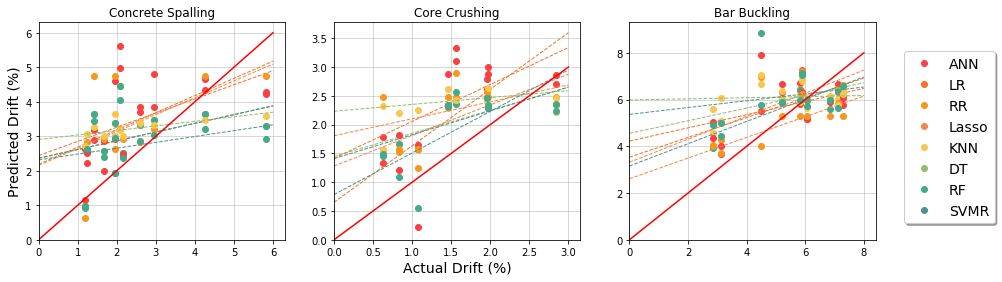

In [44]:
legend_lbl=np.array(['ANN', 'LR', 'RR', 'Lasso', 'KNN', 'DT', 'RF', 'SVMR'])
title_lbl= {0:'Concrete Spalling', 1:'Core Crushing', 2:'Bar Buckling'}

y_list_1= {0:pred_y_nn_1, 1:pred_y_lr_1, 2:pred_y_rr_1, 3:pred_y_Lasso_1, 4:pred_y_knn_1, 5:pred_y_dt_1, 6:pred_y_rf_1, 7:pred_y_svmr_1}
y_list_2= {0:pred_y_nn_2, 1:pred_y_lr_2, 2:pred_y_rr_2, 3:pred_y_Lasso_2, 4:pred_y_knn_2, 5:pred_y_dt_2, 6:pred_y_rf_2, 7:pred_y_svmr_2}
y_list_3= {0:pred_y_nn_3, 1:pred_y_lr_3, 2:pred_y_rr_3, 3:pred_y_Lasso_3, 4:pred_y_knn_3, 5:pred_y_dt_3, 6:pred_y_rf_3, 7:pred_y_svmr_3}
perf_fit = [[0,6],[0,3],[0,8]]
x_list= {0:test_y_2, 1:test_y_1, 2:test_y_3}
y_all= {0:y_list_2, 1:y_list_1, 2:y_list_3}

palette = ["#F94144", "#F3722C", "#F8961E", "#F9844A", "#F9C74F", "#90BE6D", "#43AA8B", "#4D908E"]
sns.set_palette(palette)
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15,4))
lgnd_h = []
for i in range(len(y_all)):
    plt_title = title_lbl.get(i) 
    for j in range(len(labels)):
        ax[i].plot(x_list.get(i),y_all.get(i).get(j), marker = 'o', lw = 0)
        if i == 0:
            lgnd_h.append(Line2D(x_list.get(i),y_all.get(i).get(j), marker = 'o', color= palette[j], lw = 0))
        # Display Linear Trendline for each series
        trend_x = np.polyfit(x_list.get(i), y_all.get(i).get(j), 1)
        trend_fit = np.poly1d(trend_x)
        ax[i].plot([0,perf_fit[i][1]],[trend_fit(0),trend_fit(perf_fit[i][1])],ls = '--',lw = 1)
    ax[i].plot(perf_fit[i],perf_fit[i], 'r-', lw = 1.5)
    ax[i].set_title(plt_title, y=1, fontsize = 12)
    ax[i].set_ylim(bottom=0); ax[i].set_xlim(left=0)
    ax[i].grid(linestyle='-', linewidth=0.5)
ax[0].set_ylabel('Predicted Drift (%)', fontsize=14)
ax[1].set_xlabel('Actual Drift (%)', fontsize=14)
ax[2].legend(handles =lgnd_h, labels = list(legend_lbl), loc='upper center', bbox_to_anchor=(1.3, .9), shadow=True, ncol=1, fontsize = 14)

## Plot Histograms for Manuscript

Text(0.5, 0, 'Drift Ratio (%) \n(f)')

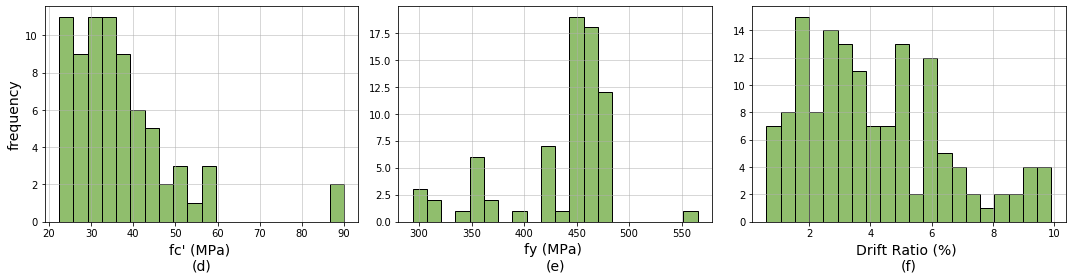

In [46]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(15,4))
n_bins = 20
ax[0].grid(linestyle='-', linewidth=0.5)
ax[0].hist(X[:,1], bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[0].set_xlabel("fc' (MPa) \n(d)", fontsize=14)
ax[0].set_ylabel("frequency", fontsize=14)

ax[1].grid(linestyle='-', linewidth=0.5)
ax[1].hist(X[:,3], bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[1].set_xlabel("fy (MPa) \n(e)", fontsize=14)

ax[2].grid(linestyle='-', linewidth=0.5)
Hist_Y = np.concatenate((Y[:,0],Y[:,1],Y[:,2]))
ax[2].hist(Hist_Y, bins=n_bins,edgecolor='black', linewidth=1, color = '#90BE6D')
ax[2].set_xlabel("Drift Ratio (%) \n(f)", fontsize=14)


## Comparison With Existing Methods

In [40]:
def Method_Comparison(actual, prediction):
    pred_ratio = []
    for i in range(len(actual)):
        pred_ratio.append(actual[i]/prediction[i])
    avg_ratio = sum(pred_ratio)/len(pred_ratio)
    std_ratio = np.std(pred_ratio)
    avg_cov = 100*std_ratio/avg_ratio
    return avg_ratio, avg_cov

if FILE_PATH == 'Rect_Dataset.xlsx':
    cs_ratio, cs_cov = Method_Comparison(test_y_2,pred_y_svmr_2)
    print("Rectangular Concrete Spalling Ratio: ",cs_ratio, "|  COV: ",cs_cov)
    print("Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio: ",round((0.03-abs(cs_ratio-1))/(0.97/100),2),"%", "|  COV: ",round((43-cs_cov)/(43/100),2),"%",'\n')
    bb_ratio, bb_cov = Method_Comparison(test_y_3,pred_y_dt_3)
    print("Rectangular Bar Buckling Ratio: ",bb_ratio, "|  COV: ",bb_cov)
    print("Improvement over Berry & Eberhard (2003) Bar Buckling Ratio: ",round((0.01-abs(bb_ratio-1))/(1.01/100),2),"%","|  COV: ",round((25-bb_cov)/(25/100),2),"%",'\n')

if FILE_PATH == 'Circ_Dataset.xlsx':
    cs_ratio, cs_cov = Method_Comparison(test_y_2,pred_y_svmr_2)
    print("Circular Concrete Spalling Ratio: ",cs_ratio, "|  COV: ",cs_cov)
    print("Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio: ",round((0.07-abs(cs_ratio-1))/(1.07/100),2),"%", "|  COV: ",round((35-cs_cov)/(35/100),2),"%",'\n')
    bb_ratio, bb_cov = Method_Comparison(test_y_3,pred_y_dt_3)
    print("Circular Bar Buckling Ratio: ",bb_ratio, "|  COV: ",bb_cov)
    print("Improvement over Berry & Eberhard (2003) Bar Buckling Ratio: ",round((0.03-abs(bb_ratio-1))/(0.97/100),2),"%", "|  COV: ",round((24-bb_cov)/(24/100),2),"%")
    print("Improvement over Goodnight (2015) Bar Buckling Ratio: ",round((0.09-abs(bb_ratio-1))/(1.09/100),2),"%", "|  COV: ",round((24.1-bb_cov)/(24.1/100),2),"%",'\n')


Circular Concrete Spalling Ratio:  0.9321735039353697 |  COV:  46.29015354832023
Improvement over Berry & Eberhard (2003) Concrete Spalling Ratio:  0.2 % |  COV:  -32.26 % 

Circular Bar Buckling Ratio:  1.0724699518108356 |  COV:  18.088089043782038
Improvement over Berry & Eberhard (2003) Bar Buckling Ratio:  -4.38 % |  COV:  24.63 %
Improvement over Goodnight (2015) Bar Buckling Ratio:  1.61 % |  COV:  24.95 % 

